This example shows how to use a `SpectralMixtureKernel` module on an `ExactGP` model. This module is designed for
- When you want to use exact inference (e.g. for regression)
- When you want to use a more sophisticated kernel than RBF

Function to be modeled is  $sin(2\pi x)$

The Spectral Mixture (SM) kernel was invented and discussed in this paper:
https://arxiv.org/pdf/1302.4245.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
from torch.autograd import Variable
# Training data points are located every 0.075 along 0 to 0.75 inclusive
train_x = Variable(torch.linspace(0, 0.75, 11))
# True function is sin(2*pi*x)
# Gaussian noise N(0,0.04) added
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)))# + torch.randn(train_x.size()) * 0.2)

In [12]:
from torch import optim
from gpytorch.kernels import RBFKernel, SpectralMixtureKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [13]:
# Here we see an example of using the spectral mixture kernel as described here:
# https://arxiv.org/pdf/1302.4245.pdf
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        # We can learn a mean between -1 and 1
        self.mean_module = ConstantMean()
        # We use a spectral mixture kernel where the frequency is a mixture of 3 Gaussians
        self.covar_module = SpectralMixtureKernel(n_mixtures=3)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

# Initialize the likelihood. We use a Gaussian for regression to get predictive mean
# and variance and learn noise parameter
likelihood = GaussianLikelihood()
# Use the likelihood to initialize the model
model = SpectralMixtureGPModel(train_x.data, train_y.data, likelihood)

In [14]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero previously backpropped gradients
    optimizer.zero_grad()
    # Make prediction
    output = model(train_x)
    # Calc loss and backprop
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.data[0]))
    optimizer.step()

Iter 1/50 - Loss: 1.444
Iter 2/50 - Loss: 1.377
Iter 3/50 - Loss: 1.296
Iter 4/50 - Loss: 1.225
Iter 5/50 - Loss: 1.166
Iter 6/50 - Loss: 1.098
Iter 7/50 - Loss: 1.037
Iter 8/50 - Loss: 0.982
Iter 9/50 - Loss: 0.931
Iter 10/50 - Loss: 0.886
Iter 11/50 - Loss: 0.846
Iter 12/50 - Loss: 0.812
Iter 13/50 - Loss: 0.782
Iter 14/50 - Loss: 0.754
Iter 15/50 - Loss: 0.725
Iter 16/50 - Loss: 0.696
Iter 17/50 - Loss: 0.665
Iter 18/50 - Loss: 0.629
Iter 19/50 - Loss: 0.590
Iter 20/50 - Loss: 0.547
Iter 21/50 - Loss: 0.501
Iter 22/50 - Loss: 0.454
Iter 23/50 - Loss: 0.409
Iter 24/50 - Loss: 0.367
Iter 25/50 - Loss: 0.329
Iter 26/50 - Loss: 0.295
Iter 27/50 - Loss: 0.266
Iter 28/50 - Loss: 0.232
Iter 29/50 - Loss: 0.196
Iter 30/50 - Loss: 0.156
Iter 31/50 - Loss: 0.108
Iter 32/50 - Loss: 0.062
Iter 33/50 - Loss: 0.014
Iter 34/50 - Loss: -0.029
Iter 35/50 - Loss: -0.067
Iter 36/50 - Loss: -0.104
Iter 37/50 - Loss: -0.149
Iter 38/50 - Loss: -0.199
Iter 39/50 - Loss: -0.257
Iter 40/50 - Loss: -0.311
It

tensor(1.00000e-02 *
       2.7912)


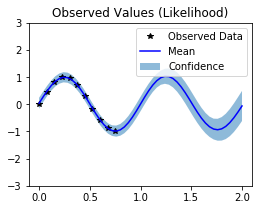

In [17]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize figure
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points every 0.1 between 0 and 5
# (note this is over 6 times the length of the region with training points)
test_x = Variable(torch.linspace(0, 2, 51))
test_y = torch.sin(test_x * (2 * math.pi))
# Make predictions
observed_pred = likelihood(model(test_x))
print((observed_pred.mean() - test_y).abs().mean())

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive mean as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade confidence region
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    # Labels + title
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot figure
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')